In [2]:
import os
import glob
import numpy as np
import pandas as pd

# ===== CSV があるフォルダ =====
base_dir = "/work/a06/tsuda/2025_master_Tsuda/sotsuron/energy_transition_analysis/new_macro"

# energydata_*.csv を全部対象にする
csv_files = glob.glob(os.path.join(base_dir, "energydata_*.csv"))
print("見つかったファイル数:", len(csv_files))
for f in csv_files:
    print("  -", f)

if not csv_files:
    raise SystemExit("CSV が見つかりません。パスを確認してください。")

for fpath in csv_files:
    fname = os.path.basename(fpath)
    country = os.path.splitext(fname)[0].replace("energydata_", "")
    print(f"\n=== {country} ===")
    print("  入力ファイル:", fpath)

    # 1) ヘッダーありで普通に読む（1行目がヘッダー）
    df = pd.read_csv(fpath)

    # 2) 「1列目は年」とみなす（列名が Year でも Unnamed: 0 でも何でもよい）
    year_col = df.columns[0]

    # Year を数値にし、NaN 行を落とす（空行やフッターを削除）
    df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
    df = df.dropna(subset=[year_col])
    df[year_col] = df[year_col].astype(int)

    # 3) 他の列も数値にしておく
    for c in df.columns:
        if c == year_col:
            continue
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # 4) Coal 列を探し、そこから右側を modern energy とみなす
    cols = list(df.columns)
    cols_lower = [str(c).strip().lower() for c in cols]
    try:
        idx_coal = cols_lower.index("coal")
    except ValueError:
        print("  'Coal' 列が見つかりません。スキップします。")
        print("  df.columns =", list(df.columns))
        continue

    modern_cols = cols[idx_coal:]                 # Coal 以右すべて
    modern_cols_no_year = [c for c in modern_cols if c != year_col]

    print("  modern energy 列 =", modern_cols_no_year)

    # 5) modern energy rate (0〜1) を計算
    modern_share = df[modern_cols_no_year].sum(axis=1) / 100.0

    # 6) 最大値で正規化
    max_val = modern_share.max()
    if max_val == 0 or np.isnan(max_val):
        modern_share_norm = modern_share * np.nan
    else:
        modern_share_norm = modern_share / max_val

    years = df[year_col].to_numpy(dtype=int)
    modern_rate = modern_share.to_numpy(dtype=float)
    modern_rate_norm = modern_share_norm.to_numpy(dtype=float)

    # 7) npy を保存（CSV と同じフォルダに）
    out_path = os.path.join(base_dir, f"{country}.npy")
    np.save(out_path, {
        "Year": years,
        "modern_rate": modern_rate,
        "modern_rate_norm": modern_rate_norm,
    })

    print("  保存:", out_path)
    print("  年の範囲:", years.min(), "–", years.max())
    print(f"  modern_rate 最大値: {max_val:.3f}")

print("\n全て終了しました。")


見つかったファイル数: 10
  - /work/a06/tsuda/2025_master_Tsuda/sotsuron/energy_transition_analysis/new_macro/energydata_Portugal.csv
  - /work/a06/tsuda/2025_master_Tsuda/sotsuron/energy_transition_analysis/new_macro/energydata_Sweden.csv
  - /work/a06/tsuda/2025_master_Tsuda/sotsuron/energy_transition_analysis/new_macro/energydata_Italy.csv
  - /work/a06/tsuda/2025_master_Tsuda/sotsuron/energy_transition_analysis/new_macro/energydata_Netherland.csv
  - /work/a06/tsuda/2025_master_Tsuda/sotsuron/energy_transition_analysis/new_macro/energydata_Uruguay.csv
  - /work/a06/tsuda/2025_master_Tsuda/sotsuron/energy_transition_analysis/new_macro/energydata_Spain.csv
  - /work/a06/tsuda/2025_master_Tsuda/sotsuron/energy_transition_analysis/new_macro/energydata_Englandwales.csv
  - /work/a06/tsuda/2025_master_Tsuda/sotsuron/energy_transition_analysis/new_macro/energydata_Germany.csv
  - /work/a06/tsuda/2025_master_Tsuda/sotsuron/energy_transition_analysis/new_macro/energydata_France.csv
  - /work/a06/tsuda

In [6]:
import numpy as np

# 読みたい npy ファイルを指定
fname = "Sweden.npy"

data = np.load(fname, allow_pickle=True).item()

print("Keys:", data.keys())
print("Years:", data["Year"][:10], "...")                    # 最初10年だけ表示
print("modern_rate:", data["modern_rate"][:10], "...")
print("modern_rate_norm:", data["modern_rate_norm"][:10], "...")
print("Length:", len(data["Year"]))


Keys: dict_keys(['Year', 'modern_rate', 'modern_rate_norm'])
Years: [1800 1801 1802 1803 1804 1805 1806 1807 1808 1809] ...
modern_rate: [0.002 0.003 0.002 0.003 0.004 0.003 0.005 0.006 0.008 0.007] ...
modern_rate_norm: [0.00223214 0.00334821 0.00223214 0.00334821 0.00446429 0.00334821
 0.00558036 0.00669643 0.00892857 0.0078125 ] ...
Length: 209


見つかった npy: 10
国リスト: ['Canada', 'Englandwales', 'France', 'Germany', 'Italy', 'Netherland', 'Portugal', 'Spain', 'Sweden', 'Uruguay']


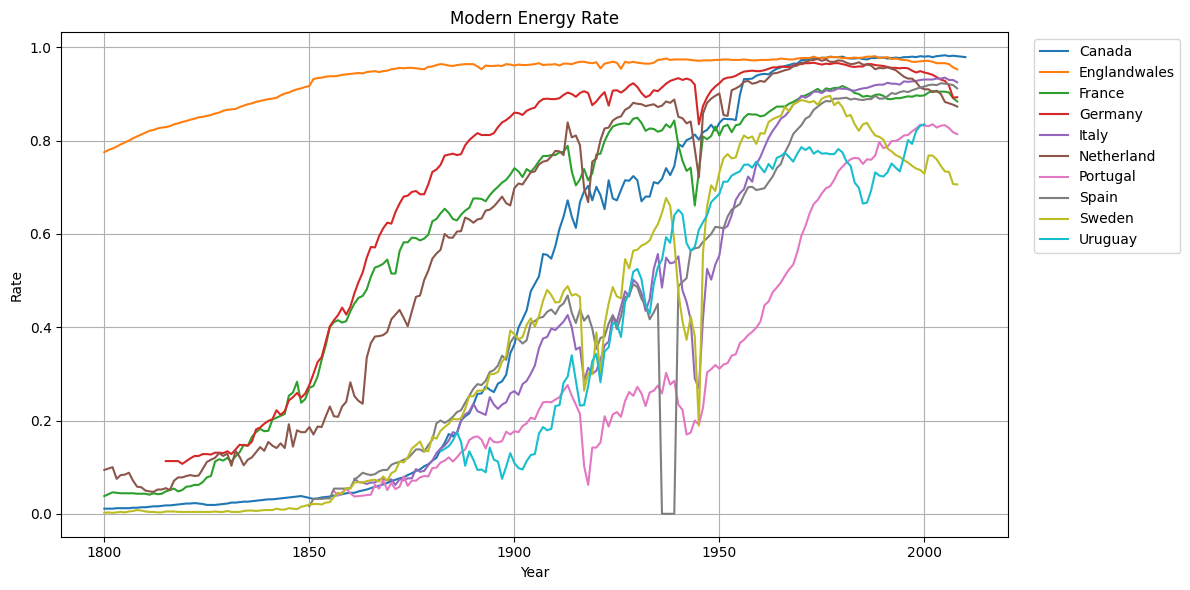

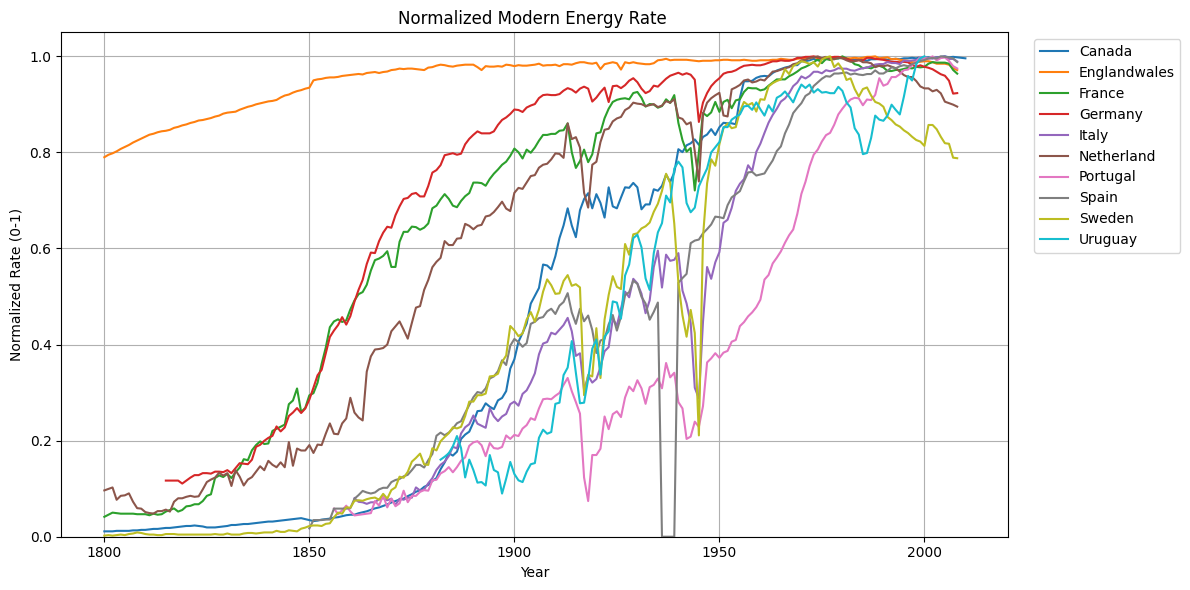

In [8]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# ★ いま 10Countries.ipynb と npy があるフォルダをベースにする
base_dir = "."   # = new_macro 内で実行している前提

# このフォルダの .npy を全部拾う
npy_files = sorted(glob.glob(os.path.join(base_dir, "*.npy")))
countries = [os.path.splitext(os.path.basename(f))[0] for f in npy_files]

print("見つかった npy:", len(npy_files))
print("国リスト:", countries)

if not npy_files:
    raise SystemExit("npy が1つも見つかっていません。カレントディレクトリを確認してください。")

# -------- 図1: modern_rate を各国まとめて --------
plt.figure(figsize=(12, 6))

for fpath, country in zip(npy_files, countries):
    data = np.load(fpath, allow_pickle=True).item()
    years = data["Year"]
    mr = data["modern_rate"]
    plt.plot(years, mr, label=country)

plt.title("Modern Energy Rate")
plt.xlabel("Year")
plt.ylabel("Rate")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# -------- 図2: modern_rate_norm を各国まとめて --------
plt.figure(figsize=(12, 6))

for fpath, country in zip(npy_files, countries):
    data = np.load(fpath, allow_pickle=True).item()
    years = data["Year"]
    mrn = data["modern_rate_norm"]
    plt.plot(years, mrn, label=country)

plt.title("Normalized Modern Energy Rate ")
plt.xlabel("Year")
plt.ylabel("Normalized Rate (0-1)")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


# check spain data lack

In [12]:
import numpy as np
np.set_printoptions(suppress=False, threshold=1000000)

fname = "Spain.npy"
data = np.load(fname, allow_pickle=True).item()

years = data["Year"]
mr    = data["modern_rate"]
mrn   = data["modern_rate_norm"]

print("=== YEARS ===")
print(years)

print("\n=== modern_rate ===")
print(mr)

print("\n=== modern_rate_norm ===")
print(mrn)


=== YEARS ===
[1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863
 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877
 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891
 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905
 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008]

=== modern_rate ===
[0.016 0.032 0.032 0.032 0.033 0.033 0.054 0.054 0.054 0.054 0.055 0.073
 0.08  0.088 0.085 0.083 0.085 0.091 0.094 0.094 0.105 0.109 0.111 0.116
 0.119 0.12

In [10]:
import numpy as np

fname = "Spain.npy"
data = np.load(fname, allow_pickle=True).item()

years = data["Year"]
mr    = data["modern_rate"]

# NaN になっているところ
nan_mask  = np.isnan(mr)
nan_years = years[nan_mask]

print("NaN の件数:", nan_mask.sum())
print("NaN の年（最初の50個だけ表示）:")
print(nan_years[:50])


NaN の件数: 0
NaN の年（最初の50個だけ表示）:
[]


In [11]:
import numpy as np

fname = "Spain.npy"
data = np.load(fname, allow_pickle=True).item()

years = data["Year"]
mr    = data["modern_rate"]

valid = ~np.isnan(mr)

segments = []
start = None
prev_y = None

for y, ok in zip(years, valid):
    if ok and start is None:
        start = y
    if ok and start is not None and prev_y is not None and y > prev_y + 1:
        # 1年以上飛んだら前の区間を閉じる
        segments.append((start, prev_y))
        start = y
    prev_y = y

# 最後の区間
if start is not None:
    segments.append((start, prev_y))

print("有効データの連続区間:")
for s, e in segments:
    print(f"{s}–{e}")


有効データの連続区間:
1850–2008
